<a href="https://colab.research.google.com/github/katherymbr/Dim_fractalMontecarlo_Sierpinskipinsk/blob/main/Sin_Metodologia_2_Dim_fractal_Montecarlo_MIAS_184.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

#  DIMENSION DE HAUSDORFF O FRACTAL, USANDO EL M√âTODO MONTECARLO+ MAMOGRAF√çAS con _MIAS_184

# IMPLEMENTACI√ìN DEL M√âTODO EN MAMOGRAFIAS

*  DIMENSION DE HAUSDORFF O FRACTAL

Despues de realizar la Calibraci√≥n del metodo de dimensi√≥n fractal integrado con montecarlo, con el triangulo de selspinski, se procedio a calcular la dimension fractal bajo este metodo en mamografias con microcalcificaciones

*  M√©todo  montecarlo

El m√©todo de Montecarlo se integrar√° al c√°lculo de la dimensi√≥n fractal. Para ello, se generar√°n puntos aleatorios dentro del viewport que cumplan con la distribuci√≥n de Montecarlo, es decir, puntos que satisfagan
ùë•
2
+
ùë¶
2
‚â§
ùëü
2
 , donde
ùëü
2
=
(
ùëô
/
2
)
2

  y
ùëô
l es el lado del viewport, el cual debe ser cuadrado. Posteriormente, en esos puntos que cumplen la distribuci√≥n de Montecarlo, se ubica la imagen dentro del viewport y se cuenta el n√∫mero de p√≠xeles para 2 divisiones del Box Counting, 4 divisiones, 16 divisiones, y as√≠ sucesivamente. Este proceso se repite para cada posici√≥n generada por Montecarlo. Finalmente, se grafica la relaci√≥n
log
‚Å°
(
1
/
boxes
)
vs.
log(N), donde la pendiente de la gr√°fica representa la dimensi√≥n fractal.


Nota: Es crucial tener precauci√≥n con los puntos de Montecarlo al posicionar la imagen dentro del viewport seg√∫n la condici√≥n establecida. Se debe evitar o RESTRINGIR que los puntos queden en las fronteras del c√≠rculo de Montecarlo, ya que esto puede resultar en que la imagen se divida entre el interior y el exterior del c√≠rculo. Este fen√≥meno es evidente en la simulaci√≥n.



```
# Proyecto 3 - Fractales
```

Autores: Katherym Bambague Ru√≠z, Ronny Guevara

*   Importo liberias

In [3]:
import imageio as io
import numpy as np
import matplotlib.pyplot as plt
from skimage import io, color, filters, data, exposure
import math
import random
import pandas  as pd
import numpy as np
from scipy.stats import linregress


In [4]:
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


# FUNCIONES

# F - VISUALIZACION Y TAMA√ëO

In [18]:
# LEER IMAGEN
def leer_imagen(rute):
  imagen= io.imread(rute)
  return(imagen)

ruta='/content/drive/MyDrive/'

In [5]:
# TAMA√ëO DE LA IMAGEN Y EL PIXEL M√ÅXIMO Y M√çNIMO

def tama√±o_imagen(imagen):
    print('dimensiones de la imagen', imagen.shape)
    print ('valor MINIMO del pixel:',imagen.min())
    print('valor M√ÅXIMO del pixel:', imagen.max())

In [6]:
# GRAFICAR 2 IMAGENES HORIZONTALES CON T√çTULO

import matplotlib.pyplot as plt

def graficar_dosimagenes_horizontaltitulo(imagen_oscura, imagen_brillante, titulo1, titulo2, tama√±o=100):
    fig, ax = plt.subplots(1, 2, dpi=tama√±o)

    # Primer subgr√°fico
    ax[0].imshow(imagen_oscura, cmap='gray')
    ax[0].set_axis_off()
    ax[0].set_title(str(titulo1))  # Utilizar set_title para establecer el t√≠tulo

    # Segundo subgr√°fico
    ax[1].imshow(imagen_brillante, cmap='gray')
    ax[1].set_axis_off()
    ax[1].set_title(str(titulo2))  # Utilizar set_title para establecer el t√≠tulo

    plt.show()

# 1.  F - DESCOMPONER IMAGEN EN SUS CANALES R,G,B

In [7]:
# FUNCI√ìN PARA DESCOMPONER LA IMAGEN EN SUS CANALES R,G,B

def image_to_rgb(imagen):

  r = imagen[:,:,0]/255.0
  g = imagen[:,:,1]/255.0
  b = imagen[:,:,2]/255.0

  return r, g, b


# 2. F - PASAR DE RGB A YIQ

In [8]:
# FUNCI√ìN PARA PASAR DE RGB A YIQ

def rgb_yiq (r1,g1,b1):

  y= 0.299*r1  +0.587*g1   +0.11*b1
  i= 0.596*r1  -0.274*g1   -0.322*b1
  q= 0.211*r1  -0.523*g1   +0.312*b1

  return(y,i,q)


Funciones para img Fito

In [9]:
# *********************
# FUNCION OARA MARCAR IMG FITO
import cv2

def area_afectada_cuatro(img5, x1, y1, x2, y2, x3, y3, x4, y4):
    img5_copy = np.copy(img5)

    # Color en formato RGB (255, 87, 51) que corresponde a #FF5733
    color = (255, 87, 51)

    # Dibuja las l√≠neas del rect√°ngulo en el color especificado
    cv2.line(img5_copy, (x1, y1), (x2, y2), color, 5)
    cv2.line(img5_copy, (x2, y2), (x3, y3), color, 5)
    cv2.line(img5_copy, (x3, y3), (x4, y4), color, 5)
    cv2.line(img5_copy, (x4, y4), (x1, y1), color, 5)

    return img5_copy


In [10]:
# funcion para CORTAR UNA IMAGEN mamaria en la imagen fito

def imagen_recorte_fito(imagen,y1,y4,x1,x2):
    imagen_recorte= imagen[y1:y4 , x1:x2]
    #graficar_imagen(imagen_recorte , 'imagen recortada', tama√±o=90)
    return(imagen_recorte)

FUNCIONES PARA MIAS

In [11]:
#funcion para dibujar area afectada de Mias
# En esta funci√≥n el origen de cordenadas est√° en la esquina inferior izquierda

def dibujar_area_afectada_mias(img, x, y, r):

    # Origen de la imagen en (x=0, y=maximo_y)
    y = img.shape[0] - y
    img_copy = np.copy(img)
    cv2.line(img_copy,(x-r,y-r),(x+r,y-r),(255,0,0),4)
    cv2.line(img_copy,(x-r,y+r),(x+r,y+r),(255,0,0),4)
    cv2.line(img_copy,(x-r,y-r),(x-r,y+r),(255,0,0),4)
    cv2.line(img_copy,(x+r,y-r),(x+r,y+r),(255,0,0),4)
    return img_copy

In [12]:
#funcion para recortar imagenes de Mias
# En esta funci√≥n el origen de cordenadas est√° en la esquina inferior izquierda

def recorte_area_afectada_mias(img, x, y, r):
  img_copy = np.copy(img)
  y = img.shape[0] - y
  img_recorte = img_copy[y-r:y+r, x-r:x+r]
  return img_recorte

#  3. F - UMBRAL OTSU - SIMPLE

In [13]:
# FUNCI√ìN PARA CALCULAR EL UMBRAL DE OTSU

def Otsu(imagen):

  umbral_otsu= filters.threshold_otsu(imagen)
  # Calcular el histograma de la imagen
  hist, bins_center = exposure.histogram(imagen)

  # Graficar el histograma
  plt.figure(figsize=(10, 5))
  plt.subplot(121)
  plt.bar(bins_center, hist, width=0.5, color='gray')
  plt.title('Histograma de la imagen')
  plt.xlabel('Intensidad de p√≠xel')
  plt.ylabel('Frecuencia')

  # Graficar el umbral de Otsu
  plt.axvline(umbral_otsu, color='r', linestyle='--', linewidth=2, label='Umbral de Otsu')
  plt.legend()

  # Mostrar la imagen original y aplicar el umbral de Otsu
  plt.subplot(122)
  plt.imshow(imagen, cmap='gray')
  plt.title('Imagen con umbral de Otsu')
  plt.axhline(umbral_otsu, color='r',linestyle='--', linewidth=0.01)
  plt.axis('off')
  plt.show()

  return umbral_otsu


# 4. F -  BINARIZAR UNA IM√ÅGEN

In [14]:
# FUNCI√ìN PARA BINARIZAR UNA IMAG√âN

def binarizacion(img_norm, umbral):

  im_binary1 = np.copy(img_norm)

  mask_1 = im_binary1 >=  umbral  # umbral_otsu
  mask_2 = im_binary1 <  umbral   # umbral_otsu

  im_binary1[mask_1] = 1 # pixeles mayores, igualeses a umbral_otsu: toman tomar el valor de 1
  im_binary1[mask_2] = 0 # pixeles menores a umbral_otsu: toman tomar el valor de 0

  print(im_binary1.shape)
  print("pixel minimo:",im_binary1.max())
  print("pixel m√°ximo:",im_binary1.min())

  return im_binary1


# 5. F - VIEWPORT CUADRADO Y PUNTOS MONTECARLO

In [15]:
# FUNCI√ìN QUE GENERA EL VIEWPORT CUADRADO A PARTIR DE UNA IMAGEN DE ENTRADA Y UN FACTOR BETA

def viewport_cuadrado(img, beta):
    "beta es el Factor de incremento del viewport con respecto a las dimensiones de la imagen"
    # Definici√≥n del √°rea del viewport
    viewport_y, viewport_x = img.shape
    print("--------------------------------------")
    print("Dimensiones de la imagen de entrada a la funci√≥n - viewport cuadrado-:", img.shape)
    # Ajustar las dimensiones para que el viewport sea cuadrado
    max_dimension = max(viewport_y, viewport_x)
    print("--------------------------------------")
    print("Se tomar√° el lado mas grande de la imagen de entrada, para formar el cuadrado:", max_dimension)
    # Ajustar las dimensiones dado el factor beta
    max_dimension = int(max_dimension * beta)
    print("--------------------------------------")
    print("El factor de incremento de la iamgen sera un factor Beta: ", beta)
    # Crear un viewport cuadrado
    viewport = np.zeros((max_dimension,  max_dimension))
    print("--------------------------------------")
    print("Dimensiones del viewport: {}".format(viewport.shape))
    print("--------------------------------------")
    return  viewport

# FUNCI√ìN PARA DIBUJAR UN CIRCULO ENCIMA DE CUALQUIER IMAGEN DE ENTRADA "cuadrada". Donde el radio del circulo es la mitad del larfo de la imagen

def generar_circulo(img):
    # Obtiene las dimensiones de la imagen
    alto_y, ancho_x = img.shape[:2]
    # Calcula el centro de la imagen
    centro_x = ancho_x / 2
    centro_y = alto_y / 2
    print("++++++++++++++++++++++++++++++++++++++")
    print("El radio del circulo dibujado es:", centro_x)
    print("++++++++++++++++++++++++++++++++++++++")
    # genera el c√≠rculo dado el centro
    circulo = plt.Circle((centro_x, centro_y), ancho_x / 2, color='blue', fill=False)
    return circulo

# Funci√≥n para verificar si un punto cumple con la condici√≥n de MONTECARLO
def verificar_condicion(x, y, ancho_x):
    return x ** 2 + y ** 2 <= (ancho_x / 2) ** 2

# FUNCION PARA GENERAR PUNTOS MONTECARLO
def generar_puntos_montecarlo(img, num_puntos):
    print("El total de puntos aleatorios a evaluar es: ", num_puntos)
    print(".....................................")
    puntos_cumplen_condicion = []
    alto_y, ancho_x = img.shape[:2]
    # Definir el n√∫mero de puntos a generar
    for i in range(num_puntos):
        # Generar coordenadas (x, y) dentro del rango especificado
        x = random.uniform(0, ancho_x)
        y = random.uniform(0, alto_y)

        # Verificar si el punto cumple con la condici√≥n
        if verificar_condicion(x - ancho_x / 2, y - alto_y / 2, ancho_x):
            puntos_cumplen_condicion.append((x, y))
    print("los puntos que cumplen la condici√≥n de montecarlo sin importar la frontera:",puntos_cumplen_condicion)
    return puntos_cumplen_condicion

#FUNCI√ìN PARA VERIFICAR SI LOS 4 PUNTOS DE LA IMAGEN QUE SE INDEXA CUMPLE CON LA CONDICION DE MONTECARLO
# Y NO SE SALEN DEL CIRCULO

def verificar_im_en_circulo(x, y, im, viewport):

    l_view = viewport.shape[0]
    y_im, x_im = im.shape
    x_real = x - l_view/2
    y_real = y - l_view/2
    x_val = None
    y_val = None

    # Verificar que la imagen no se sale del rango del circulo en ninguno de los cuadrantes
    if (verificar_condicion(y_real,        x_real,        l_view) and
        verificar_condicion(y_real + y_im, x_real,        l_view) and
        verificar_condicion(y_real + y_im, x_real + x_im, l_view) and
        verificar_condicion(y_real,        x_real + x_im, l_view)):
      x_val, y_val = x, y
    return x_val, y_val


# 6. F - BOX COUNTING

In [16]:
# **************************** Box counting ***********************************************

# Invoco la funci√≥n: def box_counting2(img, viewport, x_val, y_val)
# viewport debe ser cuadrado

def box_counting2(img, viewport, x_val, y_val):

    y_im, x_im = img.shape
    viewport[y_val:y_val+y_im, x_val:x_val+x_im] = img

    viewport_y, viewport_x = viewport.shape

    # Obtengo la dimensi√≥n m√≠nima del viewport (ahora cuadrado)
    min_axes = min(viewport.shape)

    # Obtener la mayor potencia de 2 que sea menor al valor de min_axes
    nbase = 2 ** np.floor(np.log(min_axes) / np.log(2))

    # Se obtiene el exponente
    n = int(np.log(nbase) / np.log(2))

    #se obtiene el tama√±o de los boxes
    # Se obtienen los boxes (media) en base 2^n  hasta 2^1
    boxes = 2 ** np.arange(1, n + 1, 1)[::-1]


    # Contar los pixeles en cada box para cada partici√≥n 2^n
    # Considerando el tama√±o de los boxes se cuentan los pixeles que hay en cada box, para cada partici√≥n 2^n
    counts = []
    for box in boxes:
        bc = np.add.reduceat(
            np.add.reduceat(viewport, np.arange(0, viewport_y, box), axis=0),
            np.arange(0, viewport_x, box), axis=1)
        # Se cuentan el n√∫mero de box cuya suma de pixels sea mayor a 0 y menor box^2
        counts.append(len(np.where((bc > 0) & (bc < box ** 2))[0]))

    log_inv_boxes_X = np.log(1 / boxes)
    log_counts_y = np.log(counts)
    #print(log_counts_y )


    return log_inv_boxes_X[::-1], log_counts_y[::-1]


EJECUCUI√ìN

dimensiones de la imagen (1024, 1024)
valor MINIMO del pixel: 0
valor M√ÅXIMO del pixel: 235


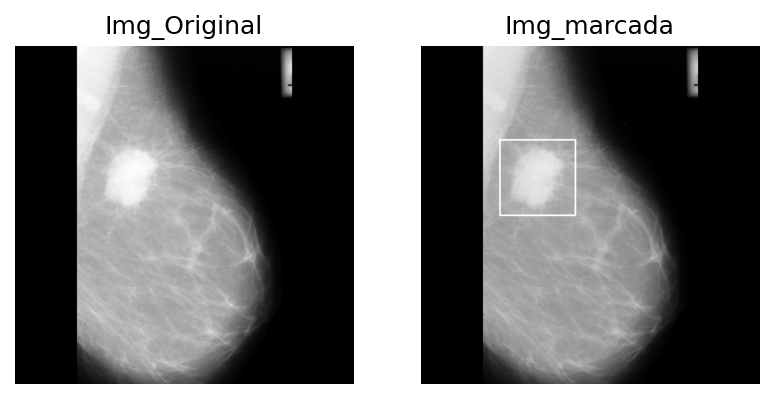

In [19]:
# Leo la imagen de la mamografia Original
#  MIAS 184
# SPIC Masas espiculadas


img_original = leer_imagen (ruta+'mdb184.pgm')
tama√±o_imagen(img_original)

imagen_marcada = dibujar_area_afectada_mias(img_original,352, 624, 114)

graficar_dosimagenes_horizontaltitulo(img_original, imagen_marcada,'Img_Original', 'Img_marcada', tama√±o=150)


tama√±o recorte de la img original: 
dimensiones de la imagen (228, 228)
valor MINIMO del pixel: 144
valor M√ÅXIMO del pixel: 234
tama√±o recorte de la img original despu√©s de NORMALIZAR: 
dimensiones de la imagen (228, 228)
valor MINIMO del pixel: 0.0
valor M√ÅXIMO del pixel: 1.0


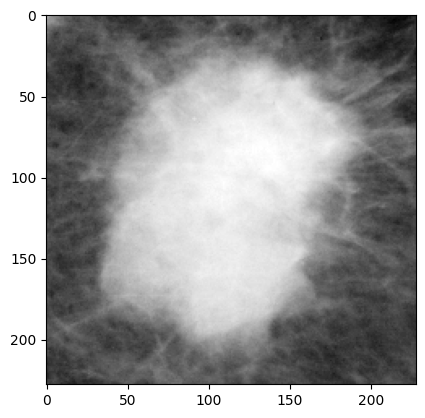

In [20]:

# Invoco una funcion para CORTAR UNA IMAGEN mamaria

imagen_recorte= recorte_area_afectada_mias(img_original, 352, 624, 114)  # hago el recorte a la imagen original
print("tama√±o recorte de la img original: ")
tama√±o_imagen(imagen_recorte)

#Normalizo el recorte de la imagen original

imagen_recorte_norm=(imagen_recorte - imagen_recorte.min()) / (imagen_recorte.max() - imagen_recorte.min())  # normalizo la imagen y la llevo a la escala de 0 a 1
print("tama√±o recorte de la img original despu√©s de NORMALIZAR: ")
tama√±o_imagen(imagen_recorte_norm)
plt.imshow(imagen_recorte_norm, cmap='gray')

In [ ]:
# Descompongo la imagen en R, G, B

#r1,g1,b1= image_to_rgb(imagen1)


In [ ]:
# Paso la imagen del espacio RGB al espacio YIQ. Tomo las luminancias Y.
"""
y1,i1,q1= rgb_yiq (r1,g1,b1)
print(y1.shape)
print("pixel minimo:",y1.max())
print("pixel m√°ximo:",y1.min())
plt.imshow( y1, cmap='gray')
"""

'\ny1,i1,q1= rgb_yiq (r1,g1,b1)\nprint(y1.shape)\nprint("pixel minimo:",y1.max())\nprint("pixel m√°ximo:",y1.min())\nplt.imshow( y1, cmap=\'gray\')\n'

In [ ]:
# Normalizo la imagen que est√° en el espacio de luminancias (Y)
"""
#normalizo la imagen y la llevo a la escala de 0 a 1
imagen1_copy_norm=(y1 - y1.min()) / (y1.max() - y1.min())
print(imagen1_copy_norm.shape)
print("pixel minimo:",imagen1_copy_norm.max())
print("pixel m√°ximo:",imagen1_copy_norm.min())
"""

'\n#normalizo la imagen y la llevo a la escala de 0 a 1\nimagen1_copy_norm=(y1 - y1.min()) / (y1.max() - y1.min())\nprint(imagen1_copy_norm.shape)\nprint("pixel minimo:",imagen1_copy_norm.max())\nprint("pixel m√°ximo:",imagen1_copy_norm.min())\n'

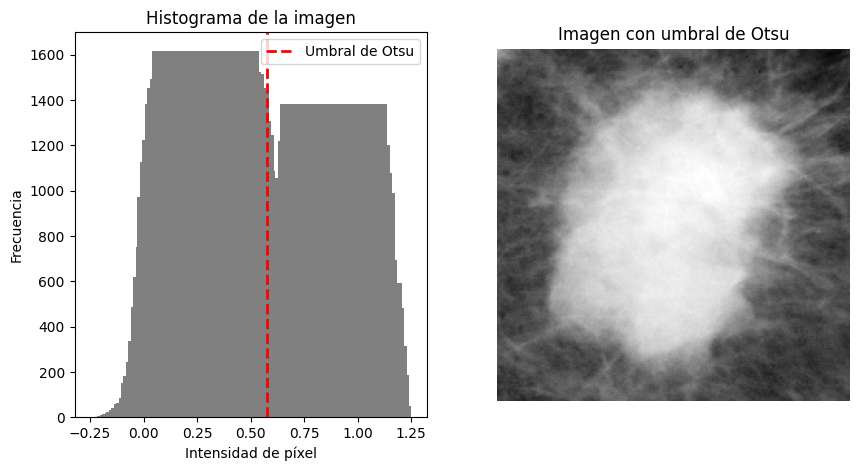

EL UMBRAL DE OTSU ES: 0.576171875


In [21]:
# Aplico la funci√≥n para encontrar el Umbral de Otsu  en imagenes normaizadas entre 0 y 1. Despu√©s grafico

umbral_otsu = Otsu(imagen_recorte_norm)
print("EL UMBRAL DE OTSU ES:",umbral_otsu)


BINARIZACI√ìN: Se binariza la imagen usando el umbral de Otsu obtenido anteriormente

(228, 228)
pixel minimo: 1.0
pixel m√°ximo: 0.0


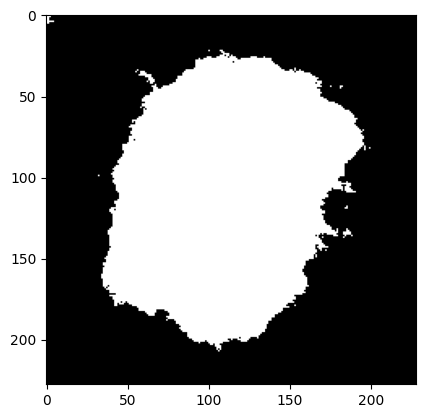

In [22]:
# Binarizo la imagen usando el umbral de OTSU y la funci√≥n para binarizar

img_binarizada= binarizacion(imagen_recorte_norm,  umbral_otsu)
plt.imshow(img_binarizada, cmap='gray')


## INVOCO LAS FUNCIONES PARA VIERPORT CUADRADO Y MONTECARLO

In [23]:
# Uso las funciones que estan en. 5.VIEWPORT CUADRADO Y PUNTOS MONTECARLO

# Invoco:  def viewport_cuadrado(img, beta):
view_cuadrado = viewport_cuadrado(img_binarizada, beta=5)

# Invoco: def generar_circulo(img):
circulo = generar_circulo(view_cuadrado)


# Invoco: def generar_puntos_montecarlo(img, num_puntos=50):
puntos_montecarlo = generar_puntos_montecarlo(view_cuadrado, num_puntos=100) #*****////////////aqui cambio el nro de puntos

# Verifico que haya puntos generados, no esten en la frontera y se puedan dibujar dentro del circulo sin que qeude algo por fuera
if puntos_montecarlo:
    x_dentro, y_dentro = zip(*puntos_montecarlo)
    x_val_list = []
    y_val_list = []
    for punto in range(len(x_dentro)):
      # Invoco: def verificar_im_en_circulo(x, y, im, viewport):
      # Verifico que los puntos se puedan dibujar y no esten en la frontera del circulo montecarlo
      # Se evaluan los 4 puntos de la imagen
      x_val, y_val = verificar_im_en_circulo(x_dentro[punto], y_dentro[punto], img_binarizada, view_cuadrado)
      if x_val:
        x_val_list.append(x_val)
        y_val_list.append(y_val)

    print('N√∫mero total de puntos que cumplen la condici√≥n MONTECARLO: ', len(x_dentro))
    print("*************************************")
    # Puntos que no estan en la frontera del circulo MOntecarlo y SI se pueden dibujar
    print('N√∫mero de puntos que cumplen MONTECARLO y SI se pueden dibujar: ', len(x_val_list))
    print("puntos a dibujar en x:", x_val_list )
    print("puntos a dibujar en y:", y_val_list )
    print("*************************************")



--------------------------------------
Dimensiones de la imagen de entrada a la funci√≥n - viewport cuadrado-: (228, 228)
--------------------------------------
Se tomar√° el lado mas grande de la imagen de entrada, para formar el cuadrado: 228
--------------------------------------
El factor de incremento de la iamgen sera un factor Beta:  5
--------------------------------------
Dimensiones del viewport: (1140, 1140)
--------------------------------------
++++++++++++++++++++++++++++++++++++++
El radio del circulo dibujado es: 570.0
++++++++++++++++++++++++++++++++++++++
El total de puntos aleatorios a evaluar es:  100
.....................................
los puntos que cumplen la condici√≥n de montecarlo sin importar la frontera: [(452.7251821090355, 757.5902649056134), (452.6372547845279, 210.32971101577368), (335.31986822178976, 953.9359183125356), (154.83818767318536, 448.61301151578203), (919.0507319400953, 501.8603173109318), (706.7177828894166, 332.78194069673145), (467.85307

## Visualizar solo viewport y puntos

In [ ]:
"""
plt.imshow(view_cuadrado, cmap='gray')  # Usa cmap='gray' si la imagen es en blanco y negro
plt.scatter(x_dentro, y_dentro, color='red')
plt.scatter(x_val_list, y_val_list, color='green')
plt.gca().add_artist(circulo)
"""

"\nplt.imshow(view_cuadrado, cmap='gray')  # Usa cmap='gray' si la imagen es en blanco y negro\nplt.scatter(x_dentro, y_dentro, color='red')\nplt.scatter(x_val_list, y_val_list, color='green')\nplt.gca().add_artist(circulo)\n"

## Visualizar viewport, putos y la imagen en todas las posiciones validas

In [ ]:
"""
for puntos in range(len(x_val_list)):
  x_d, y_d = int(x_val_list[puntos]), int(y_val_list[puntos])
  y_im, x_im = img_binarizada.shape
  view_cuadrado[y_d:y_d+y_im, x_d:x_d+x_im] = img_binarizada
  plt.imshow(view_cuadrado, cmap='gray')  # Usa cmap='gray' si la imagen es en blanco y negro
  #plt.scatter(x_dentro, y_dentro, color='red')
  plt.scatter(x_val_list, y_val_list, color='green')
  plt.gca().add_artist(circulo)
"""

"\nfor puntos in range(len(x_val_list)):\n  x_d, y_d = int(x_val_list[puntos]), int(y_val_list[puntos])\n  y_im, x_im = img_binarizada.shape\n  view_cuadrado[y_d:y_d+y_im, x_d:x_d+x_im] = img_binarizada\n  plt.imshow(view_cuadrado, cmap='gray')  # Usa cmap='gray' si la imagen es en blanco y negro\n  #plt.scatter(x_dentro, y_dentro, color='red')\n  plt.scatter(x_val_list, y_val_list, color='green')\n  plt.gca().add_artist(circulo)\n"

*  Invoco la funci√≥n  Box counting

In [24]:
# Verificar si las variables son None y proporcionar valores predeterminados si es necesario
if x_val is None:
    x_val = 0  # O cualquier otro valor predeterminado adecuado
if y_val is None:
    y_val = 0  # O cualquier otro valor predeterminado adecuado

# Asegurarse de que x_val y y_val no sean None antes de la conversi√≥n
try:
    x_val_int = int(x_val)
    y_val_int = int(y_val)
except TypeError as e:
    print(f"Error al convertir x_val o y_val a entero: {e}")
    # Manejar el error seg√∫n sea necesario, por ejemplo, salir de la funci√≥n o usar valores predeterminados
    x_val_int = 0  # O manejarlo de otra manera adecuada
    y_val_int = 0  # O manejarlo de otra manera adecuada

# Llamar a la funci√≥n con los valores convertidos
boxes, count = box_counting2(img_binarizada, view_cuadrado, x_val_int, y_val_int)
print(boxes)


[-0.69314718 -1.38629436 -2.07944154 -2.77258872 -3.4657359  -4.15888308
 -4.85203026 -5.54517744 -6.23832463 -6.93147181]


In [25]:
# INVOCO LA FUNCION BOX COUNTING NUEVA

# Inicializar listas para almacenar los resultados
lista_log_inv_boxes_X=[]
lista_log_counts_y= []

# Recorrer cada par de coordenadas y obtener los resultados
for x_val, y_val in zip(x_val_list, y_val_list):
  log_inv_boxes_X, log_counts_y = box_counting2(img_binarizada, view_cuadrado, int(x_val), int(y_val))
  lista_log_inv_boxes_X.append(log_inv_boxes_X)
  lista_log_counts_y.append(log_counts_y)


In [27]:

# Convertir lista_log_counts_y en una matriz de numpy
# Aqui estan las cuentas de cuantos pixeles hay en cada (1/boxes)

matriz_log_counts_y = np.array(lista_log_counts_y)
print("Tama√±o de matriz_log_counts_y, es:",matriz_log_counts_y.shape)
#print(matriz_log_counts_y)

#convierto x_val_list en un vector
vector_x_val_list= np.array(x_val_list)
#print("Tama√±o del vector_x_val_list, es:",vector_x_val_list.shape) # (24,),significa un arreglo unidimensional con 24 elementos.1 fila,24 columnas
print("Tama√±o del vector_x_val_list, es:",len(x_val_list))
num_puntos=len(x_val_list)
#print(vector_x_val_list)

#convierto y_val_list en un vector
vector_y_val_list= np.array(y_val_list)
print("Tama√±o del vector_y_val_list, es:",vector_y_val_list.shape) # (24,),significa un arreglo unidimensional con 24 elemrntos
#print(vector_y_val_list)

Tama√±o de matriz_log_counts_y, es: (41, 10)
Tama√±o del vector_x_val_list, es: 41
Tama√±o del vector_y_val_list, es: (41,)


In [28]:
# llevamos los vecores: vector_x_val_list(20), vector_y_val_list(20), a las mismas dimensiones de la matriz matriz_log_counts_y ((20, 12))
# como vector_x_val_list, tiene 20 filas y vector_y_val_list,  tiene 20 filas, los paso a vectores columnna, para que queden con la misma dimension de la matriz
#luego concatenar por columnas para construir la tablas

# Transformar en un vector columna con 20 filas y 1 columna
vector_x_val_list_columna = vector_x_val_list.reshape(num_puntos, 1)
print("Tama√±o del vector_x_val_list, es:",vector_x_val_list_columna.shape)

#convierto y_val_list en un vector
#vector_y_val_list= np.array(y_val_list)
vector_y_val_list_columna = vector_x_val_list.reshape(num_puntos, 1)
print("Tama√±o del vector_y_val_list, es:", vector_y_val_list_columna.shape)



Tama√±o del vector_x_val_list, es: (41, 1)
Tama√±o del vector_y_val_list, es: (41, 1)


In [29]:
# Ahora concatenamos: vector_x_val_list_columna + vector_y_val_list_columna + matriz_log_counts_y. Para formar la tabla

tabla = np.concatenate((vector_x_val_list_columna, vector_y_val_list_columna, matriz_log_counts_y), axis=1)

print("El tama√±o de la tabla es: ",tabla.shape)
#tabla

El tama√±o de la tabla es:  (41, 12)


In [30]:
#df=pd.DataFrame(tabla, columns=["x","y","box2","box4","box8","box16" , "box32","box64","box128","box256","box512","box1024","box2048","box4096"])
df=pd.DataFrame(tabla, columns=["x","y","box2","box4","box8","box16" , "box32","box64","box128","box256","box512","box1024"])
#df = pd.DataFrame(tabla)
df.head(100)

x           y      box2      box4      box8     box16     box32  \
0   452.725182  452.725182  6.395262  5.958425  5.298317  4.553877  3.850148   
1   452.637255  452.637255  6.786717  6.349139  5.700444  4.969813  4.262680   
2   154.838188  154.838188  7.067320  6.642487  5.986452  5.257495  4.564348   
3   706.717783  706.717783  7.286192  6.869014  6.202536  5.484797  4.762174   
4   467.853074  467.853074  7.348588  6.972606  6.295266  5.583496  4.867534   
5   511.966175  511.966175  7.395108  7.006695  6.320768  5.594711  4.875197   
6   776.173580  776.173580  7.570443  7.170888  6.490724  5.768321  5.049856   
7   555.926572  555.926572  7.673688  7.225481  6.559615  5.837730  5.123964   
8   359.924381  359.924381  7.703008  7.266827  6.620073  5.908083  5.176150   
9   427.908756  427.908756  7.807103  7.347300  6.697034  5.973810  5.241747   
10  562.315157  562.315157  7.855932  7.418781  6.765039  6.042633  5.308268   
11  654.195641  654.195641  7.963808  7.528332  6.873164  6.148468  5.420535   
12  598.075271  598.075271  7.942718  7.545918  6.891626  6.173786  5.429346   
13  656.798853  656.798853  7.967973  7.562681  6.916715  6.194405  5.468060   
14  564.801786  564.801786  7.951207  7.549083  6.933423  6.234411  5.517453   
15  433.888374  433.888374  8.025516  7.614805  6.995766  6.295266  5.579730   
16  695.758322  695.758322  8.044305  7.622664  7.000334  6.298949  5.587249   
17  582.110033  582.110033  8.086103  7.665753  7.038784  6.331502  5.609472   
18  272.483482  272.483482  8.126518  7.696667  7.072422  6.363028  5.662960   
19  770.461210  770.461210  8.118505  7.685244  7.063904  6.350886  5.645447   
20  517.874149  517.874149  8.144389  7.716015  7.096721  6.378426  5.673323   
21  144.659672  144.659672  8.231110  7.798523  7.177019  6.455199  5.752573   
22  528.720481  528.720481  8.226306  7.794411  7.153052  6.429719  5.746203   
23  502.036071  502.036071  8.200837  7.799343  7.152269  6.437752  5.762051   
24  346.971359  346.971359  8.244071  7.853216  7.207860  6.504288  5.817111   
25  174.353719  174.353719  8.254009  7.877018  7.230563  6.523562  5.817111   
26  855.779249  855.779249  8.302762  7.922261  7.283448  6.584791  5.869297   
27  446.747272  446.747272  8.337827  7.968320  7.325149  6.613384  5.886104   
28  736.796371  736.796371  8.385032  7.992607  7.344719  6.629363  5.899897   
29  354.218730  354.218730  8.406485  8.026170  7.372118  6.655440  5.913503   
30  240.578424  240.578424  8.406262  8.031385  7.389564  6.666957  5.940171   
31  191.551210  191.551210  8.397283  8.051022  7.415777  6.690842  5.945421   
32  230.066602  230.066602  8.411833  8.078068  7.447751  6.731018  5.981414   
33  607.141483  607.141483  8.397959  8.064636  7.438972  6.725034  5.978886   
34  412.387434  412.387434  8.422663  8.088562  7.459915  6.742881  5.988961   
35  323.116912  323.116912  8.426612  8.079618  7.459915  6.738152  5.991465   
36  406.037553  406.037553  8.416267  8.089176  7.473069  6.767343  6.013715   
37  689.113514  689.113514  8.424639  8.074649  7.462789  6.751101  6.003887   
38  638.571767  638.571767  8.414496  8.068090  7.448916  6.741701  5.996452   
39  879.633629  879.633629  8.421343  8.072779  7.452402  6.734592  5.993961   
40  323.258838  323.258838  8.463581  8.079618  7.450080  6.733402  5.996452   

       box64    box128    box256    box512   box1024  
0   3.135494  2.302585  1.386294  1.098612  0.000000  
1   3.583519  2.833213  2.079442  1.386294  0.000000  
2   3.891820  3.135494  2.302585  1.386294  0.000000  
3   4.094345  3.367296  2.564949  1.386294  0.000000  
4   4.158883  3.367296  2.564949  1.386294  0.000000  
5   4.174387  3.367296  2.564949  1.386294  0.000000  
6   4.356709  3.526361  2.639057  1.386294  0.000000  
7   4.382027  3.526361  2.639057  1.386294  0.000000  
8   4.418841  3.555348  2.639057  1.386294  0.000000  
9   4.454347  3.555348  2.639057  1.386294  0.000000  
10  4.521789  3.637586  2.639057  1.386294  0.0

In [31]:
# paso 1 - cuaderno
# El vector boxes_matriz lo convierto en una matriz, para lo cual lo multiplico por  una matriz de unos

matrix_ones=np.ones((matriz_log_counts_y.shape))
print("Tama√±o de matrix_ones, es:",matrix_ones.shape)
#print(matrix_ones)


Tama√±o de matrix_ones, es: (41, 10)


In [32]:
# paso 1 - cuaderno
# Visualicemos el vecto inicial de boxes

boxes
print(boxes)

[-0.69314718 -1.38629436 -2.07944154 -2.77258872 -3.4657359  -4.15888308
 -4.85203026 -5.54517744 -6.23832463 -6.93147181]


In [33]:
# paso 1 - cuaderno
# El vector boxes_matriz lo convierto en una matriz, para lo cual lo multiplico por  una matriz de unos
# Hago el prouducto entre el vector de boxes y la matriz de unos

boxesboxes_matriz= boxes * matrix_ones
print("Tama√±o de boxesboxes_matriz, es:",boxesboxes_matriz.shape)
#print(boxesboxes_matriz)

Tama√±o de boxesboxes_matriz, es: (41, 10)


In [34]:
# paso 2 - cuaderno
# Hago la transpuesta de boxesboxes_matriz

boxesboxes_matriz_transpuesta=boxesboxes_matriz.T
print("Tama√±o de boxesboxes_matriz_transpuesta, es:",boxesboxes_matriz_transpuesta.shape)
#print(boxesboxes_matriz_transpuesta)



Tama√±o de boxesboxes_matriz_transpuesta, es: (10, 41)


In [35]:
# paso 2 - cuaderno
# Hago la transpuesta de matriz_log_counts_y

matriz_log_counts_y_transpuesta=matriz_log_counts_y.T
print("Tama√±o de matriz_log_counts_y_transpuesta, es:",matriz_log_counts_y_transpuesta.shape)
#print(matriz_log_counts_y_transpuesta)



Tama√±o de matriz_log_counts_y_transpuesta, es: (10, 41)


In [36]:
# paso 3 - cuaderno
# Hago reshape a matriz_log_counts_y_transpuesta y boxesboxes_matriz_transpuesta para que queden en una sola columna
# Reorganizar la matriz matriz_log_counts_y_transpuesta a una forma de 12 filas y 1 columna


# Reorganizar la matriz a una sola columna
matriz_log_counts_y_transpuesta_reshape = matriz_log_counts_y_transpuesta.reshape(-1, 1)

# Imprimir el tama√±o de la nueva matriz
print("Tama√±o de matriz_log_counts_y_reshape:", matriz_log_counts_y_transpuesta_reshape.shape)

# Imprimir la nueva matriz reorganizada
#print(matriz_log_counts_y_transpuesta_reshape)


Tama√±o de matriz_log_counts_y_reshape: (410, 1)


In [37]:
# paso 3 - cuaderno
# Hago reshape a matriz_log_counts_y_transpuesta y boxesboxes_matriz_transpuesta para que queden en una sola columna
# Reorganizar la matriz matriz_log_counts_y_transpuesta a una forma de 12 filas y 1 columna


# Reorganizar la matriz a una sola columna
boxesboxes_matriz_transpuesta_reshape = boxesboxes_matriz_transpuesta.reshape(-1, 1)
print("Tama√±o de boxesboxes_matriz_transpuesta_reshape:", boxesboxes_matriz_transpuesta_reshape.shape)
#print(boxesboxes_matriz_transpuesta_reshape)

Tama√±o de boxesboxes_matriz_transpuesta_reshape: (410, 1)


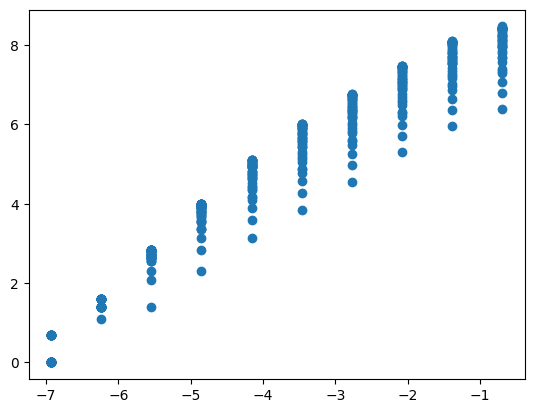

In [38]:
# Grafiicar  boxesboxes_matriz_transpuesta_reshape vs. matriz_log_counts_y_transpuesta_reshape

plt.scatter(boxesboxes_matriz_transpuesta_reshape, matriz_log_counts_y_transpuesta_reshape)

## Dim fractal final- Mamografia

la dimensi√≥n fractal de la mamografia es: 1.2484843470512044
Slope: 1.2484843470512044
Intercept: 9.481691995922365
R-squared: 0.9532837846776451
P-value: 1.5068907878313167e-273
Standard error: 0.013682824073176192


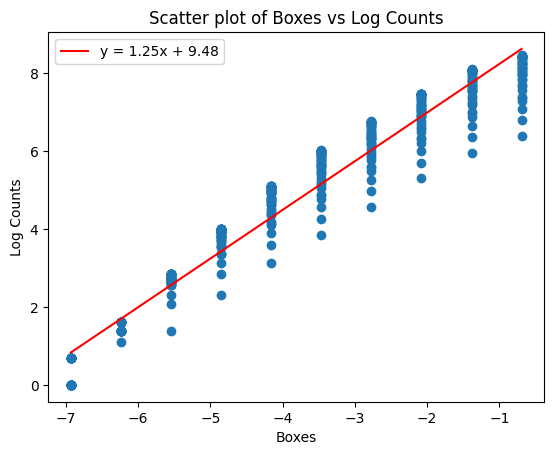

In [40]:

# Asegurarse de que las matrices est√°n en la forma correcta
boxesboxes_matriz_transpuesta_reshape = boxesboxes_matriz_transpuesta_reshape.reshape(-1)
matriz_log_counts_y_transpuesta_reshape = matriz_log_counts_y_transpuesta_reshape.reshape(-1)

# Verificar que ambas matrices tienen el mismo tama√±o
assert boxesboxes_matriz_transpuesta_reshape.shape == matriz_log_counts_y_transpuesta_reshape.shape, "Las matrices deben tener el mismo tama√±o"

# Graficar scatter plot
plt.scatter(boxesboxes_matriz_transpuesta_reshape, matriz_log_counts_y_transpuesta_reshape)
plt.xlabel('Boxes')
plt.ylabel('Log Counts')
plt.title('Scatter plot of Boxes vs Log Counts')

# Calcular la regresi√≥n lineal
slope, intercept, r_value, p_value, std_err = linregress(boxesboxes_matriz_transpuesta_reshape, matriz_log_counts_y_transpuesta_reshape)
print("la dimensi√≥n fractal de la mamografia es:",slope)
# Imprimir los resultados de la regresi√≥n lineal
print("Slope:", slope)
print("Intercept:", intercept)
print("R-squared:", r_value**2)
print("P-value:", p_value)
print("Standard error:", std_err)

# Graficar la l√≠nea de regresi√≥n
x = np.linspace(min(boxesboxes_matriz_transpuesta_reshape), max(boxesboxes_matriz_transpuesta_reshape), 100)
y = slope * x + intercept
plt.plot(x, y, color='red', label=f'y = {slope:.2f}x + {intercept:.2f}')

plt.legend()
plt.show()
